## BCI Processing

#### Libraries

In [1]:
from scipy.stats import qmc
import numpy as np
import xarray as xr
import csv
import pandas as pd
import os
import netCDF4 as nc4
import sys
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                     
import shutil                                                                                                                                                       
import tempfile 
import random

#import functions_py.modp as mp
#import fates_xarray_functions as fa

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize

dark = cm.get_cmap('Paired', 12)
colormap = dark(range(12))
colormap[10] = colormap[11]

import functions_py.fates_xarray_functions as fa

/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# this function takes data that has monthly values and returns a single annual value, with 
# a mean that accounts for the number of days per month
def monthly_to_annual(array):
    """ calculate annual mean from monthly data, using unequal month lengths for noleap calendar.  
    originally written by Keith Lindsay."""
    mon_day  = xr.DataArray(np.array([31.,28.,31.,30.,31.,30.,31.,31.,30.,31.,30.,31.]), dims=['month'])
    mon_wgt  = mon_day/mon_day.sum()
    return (array.rolling(time=12, center=False) # rolling
            .construct("month") # construct the array
            .isel(time=slice(11, None, 12)) # slice so that the first element is [1..12], second is [13..24]
            .dot(mon_wgt, dims=["month"]))

#### Load Benchmarking Data

In [3]:
# regrowth curves 
dfre = pd.read_csv('/global/homes/j/jneedham/DBEN/benchmarking_data/benchmark_regrowth_curves.csv')
dfre = dfre[dfre.Biome == 'Tropics']

# stand structure data 
dfss = pd.read_csv('/global/homes/j/jneedham/DBEN/benchmarking_data/benchmark_stand_structure.csv')
dfss = dfss[dfss.site == 'BCI']

# equilibrium dynamics
dfeq = pd.read_csv('/global/homes/j/jneedham/DBEN/benchmarking_data/benchmark_eq_dynamics.csv')
dfeq = dfeq[dfeq.site == 'BCI']


#### Load FATES

In [4]:
ninst=7

fates_runs = []

for i in range(1,ninst+1):
    fates_tmp = '/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/bci_562_{0}.Ef14a3cf738-F2c2f3f10.2024-06-23/run/bci_562_{0}.Ef14a3cf738-F2c2f3f10.2024-06-23.sofar.nc'.format(i)
    fates_runs.append(xr.open_dataset(fates_tmp, decode_times=False))
    print(i)

1
2
3
4
5
6
7


In [5]:
nyears = int(len(fates_runs[0].variables['time'])/12)
tave_start = (nyears-5)
tave_stop = nyears

cohort_size_bins = fates_runs[0].variables['fates_levscls']
patch_age_bins = fates_runs[0].variables['fates_levage'][:]
nsizebins = len(cohort_size_bins)

# when saving outputs we convert from monthly to annual and use 0-450 as start and stop
time = fates_runs[0].variables['time'] / 365.
start_time=0
stop_time = 450
time =  time[0:stop_time]

agb_frac = 0.6

In [6]:
for i in range(0,ninst) : 
    cveg_mon  = fates_runs[i].FATES_VEGC_PF 
    cveg = monthly_to_annual(cveg_mon)
    cveg = cveg.isel(time=slice(start_time,stop_time))
    cveg = cveg.to_dataset(name='cveg')
    cveg.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_cveg_p1_bci_{0}.nc'.format(i+1))

In [7]:
for i in range(0,ninst) : 
    cveg_mon  = fates_runs[i].FATES_VEGC_PF.sum(dim='fates_levpft') + fates_runs[i].FATES_SEED_BANK
    cveg = monthly_to_annual(cveg_mon)
    cveg = cveg.isel(time=slice(start_time,stop_time))
    cveg = cveg.to_dataset(name='cveg')
    cveg.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_cveg_total_p1_bci_{0}.nc'.format(i+1))

Text(0.02, 0.5, 'Veg C (kg C m-2)')

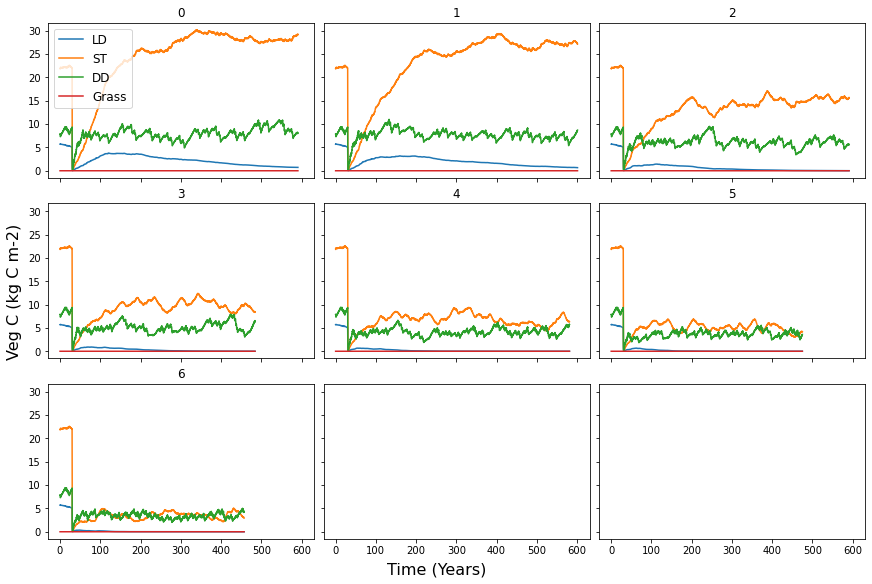

In [8]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in range(0,ninst):
    time = fates_runs[i].variables['time'] / 365.
    cveg  = fates_runs[i].FATES_VEGC_PF 
    
    axs[i].plot(time, cveg.isel(fates_levpft=0),label = 'LD')  
    axs[i].plot(time, cveg.isel(fates_levpft=1), label = 'ST')   
    axs[i].plot(time, cveg.isel(fates_levpft=2),  label = 'DD')   
    axs[i].plot(time, cveg.isel(fates_levpft=3),  label = 'Grass')  
    axs[i].set_title(i)
    if i == 0:
        axs[i].legend(prop={'size':12})

fig1.supxlabel(r'Time (Years)', fontsize=16)
fig1.supylabel(r'Veg C (kg C m-2)', fontsize=16)  

In [9]:
for i in range(0,ninst): 
    AGB = fates_runs[i].FATES_VEGC_ABOVEGROUND
    AGB = monthly_to_annual(AGB)
    AGB = AGB.isel(time=slice(start_time,stop_time))
    AGB = AGB.to_dataset(name='AGB')
    AGB.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_AGB_p1_bci_{0}.nc'.format(i+1))


In [10]:
for i in range(0,ninst):
    AGcwoody = fates_runs[i].FATES_WOODY_ABOVEGROUND
    AGcwoody = monthly_to_annual(AGcwoody)
    AGcwoody.isel(time=slice(start_time,stop_time))
    AGcwoody = AGcwoody.to_dataset(name='AGcwood')
    AGcwoody.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_AGcwood_p1_bci_{0}.nc'.format(i+1))


Text(0.02, 0.5, 'Veg C (kg C m-2)')

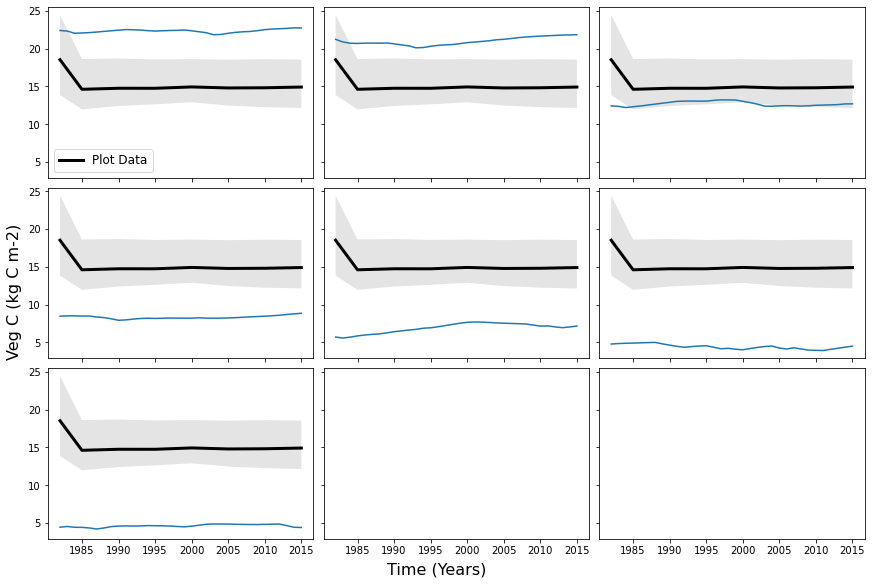

In [11]:
time_plot = list(dfeq.Year)
agb_plot = dfeq.AGB_kgCm2
agb_plot_lower = dfeq.AGB_lower_kgCm2
agb_plot_upper = dfeq.AGB_upper_kgCm2

eq_time = np.arange(time_plot[0], (time_plot[-1]+1), 1)

fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in range(0,ninst):
    nyears = int(len(fates_runs[i].variables['time'])/12)
    tstart = nyears-(len(eq_time))
    tstop = nyears
    AGB = monthly_to_annual(fates_runs[i].FATES_VEGC_ABOVEGROUND)
   
    axs[i].plot(eq_time, AGB[tstart:tstop])  
    
    axs[i].plot(time_plot, agb_plot, color='black', label = 'Plot Data', linewidth=3)
    axs[i].fill_between(time_plot, agb_plot_lower, agb_plot_upper, alpha=0.6, facecolor='lightgrey')
    if i == 0:
        axs[i].legend(prop={'size':12})

fig1.supxlabel(r'Time (Years)', fontsize=16)
fig1.supylabel(r'Veg C (kg C m-2)', fontsize=16)

### Carbon mass in wood by pft

In [12]:
for i in range(0,ninst) : 
    cwood = monthly_to_annual(fates_runs[i].FATES_WOODC_PF)
    cwood = cwood.isel(time=slice(start_time,stop_time))
    cwood = cwood.to_dataset(name='cwood')
    cwood.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_cwood_p1_bci_{0}.nc'.format(i+1))


Text(0.02, 0.5, 'Veg C (kg C m-2)')

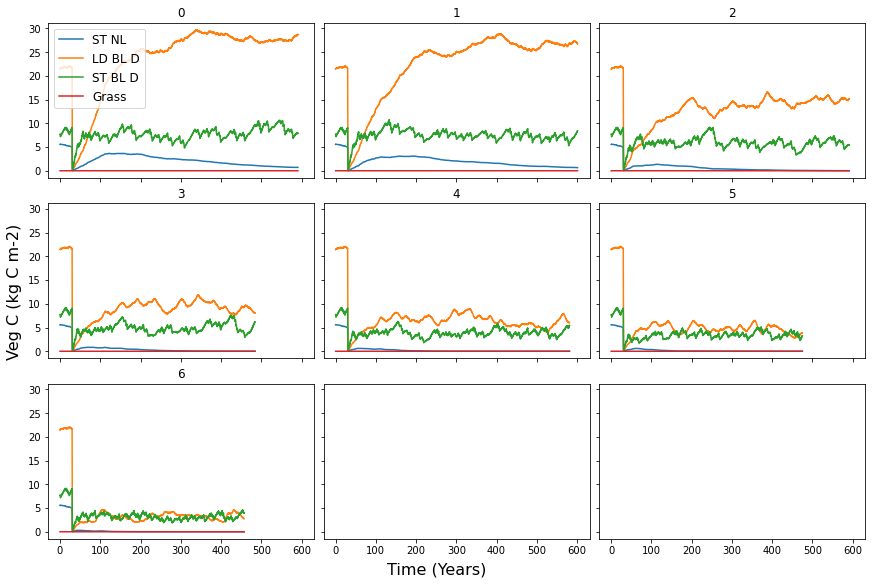

In [13]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in range(0,ninst):
    time = fates_runs[i].variables['time'] / 365.
    cwood = fates_runs[i].FATES_WOODC_PF
    
    axs[i].plot(time, cwood.isel(fates_levpft=0),label = 'ST NL')  
    axs[i].plot(time, cwood.isel(fates_levpft=1), label = 'LD BL D')   
    axs[i].plot(time, cwood.isel(fates_levpft=2),  label = 'ST BL D')   
    axs[i].plot(time, cwood.isel(fates_levpft=3),  label = 'Grass')  
    axs[i].set_title(i)
    if i == 0:
        axs[i].legend(prop={'size':12})

fig1.supxlabel(r'Time (Years)', fontsize=16)
fig1.supylabel(r'Veg C (kg C m-2)', fontsize=16)

        

### Carbon mass in woody by size class

In [14]:
for i in range(0,ninst): 
    cwood_size = monthly_to_annual(fates_runs[i].FATES_WOODC_SZ)
    cwood_size = cwood_size.isel(time=slice(start_time,stop_time))
    cwood_size = cwood_size.isel(fates_levscls=slice(1,nsizebins))  # remove first size bin (0-1)
    cwood_size = cwood_size.to_dataset(name='cwood_size')
    cwood_size.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_cwood_size_p1_bci_{0}.nc'.format(i+1))

Text(0.02, 0.5, 'Cwood (kg C m-2)')

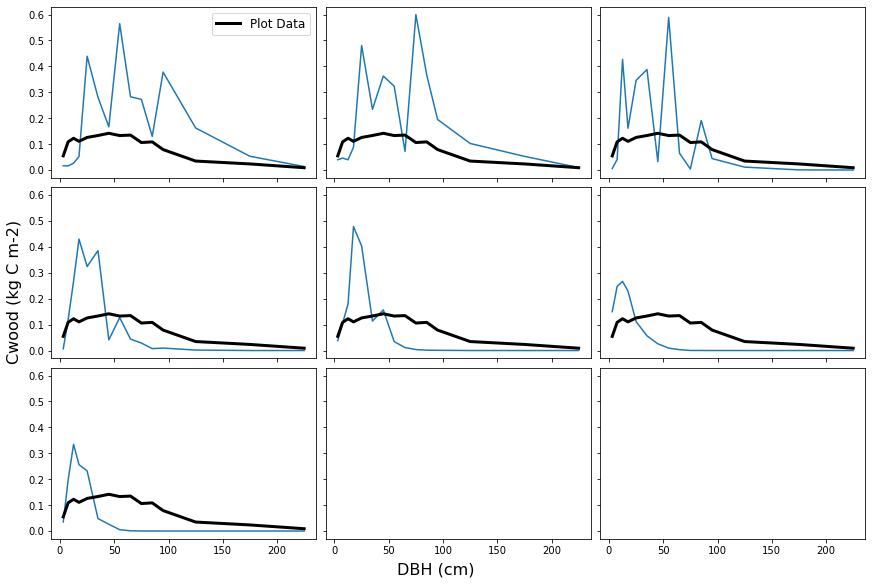

In [15]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

plot_cwood_sz = dfss['AGB_size_kgCm.2']
plot_sizebin = np.array(dfss.dbh_classes_num)
plot_sizebin_mids = (plot_sizebin[0:-1] + plot_sizebin[1:])/2
plot_sizebin_widths = plot_sizebin[1:] - plot_sizebin[:-1]

# divide by bin width
cohort_size_bins_ex = np.append(cohort_size_bins,250)
widths = cohort_size_bins_ex[1:]-cohort_size_bins_ex[:-1]
mids = (cohort_size_bins_ex[0:-1] + cohort_size_bins_ex[1:])/2

for i in range(0,ninst):
    nyears = int(len(fates_runs[i].variables['time'])/12)
    tave_start = (nyears-5)
    tave_stop = nyears
    cwood_size = monthly_to_annual(fates_runs[i].FATES_WOODC_SZ)
    cwood_size = np.squeeze(cwood_size.isel(time=slice(tave_start,tave_stop)).mean(dim='time'))
    cwood_size = cwood_size.isel(fates_levscls=slice(1,nsizebins))  # remove first size bin (0-1)
    

    axs[i].plot(mids[1:], cwood_size/widths[1:])  
    axs[i].plot(plot_sizebin_mids, plot_cwood_sz[1:]/plot_sizebin_widths, color='black',
           label = 'Plot Data', linewidth=3)

axs[0].legend(prop={'size':12})
    
fig1.supxlabel(r'DBH (cm)', fontsize=16)
fig1.supylabel(r'Cwood (kg C m-2)', fontsize=16)

### Stem number by size class

In [16]:
for i in range(0,ninst): 
    nstem_size = monthly_to_annual(fates_runs[i].FATES_NPLANT_SZ)
    nstem_size = nstem_size.isel(time=slice(start_time,stop_time))
    nstem_size = nstem_size.isel(fates_levscls=slice(1,nsizebins))  # remove first size bin (0-1)
    nstem_size = nstem_size.to_dataset(name='nstem_size')
    nstem_size.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_nstem_size_p1_bci_{0}.nc'.format(i+1))

### And the data comparison

Text(0.02, 0.5, 'Number of plants (ha$^{-1}$ cm$^{-1}$)')

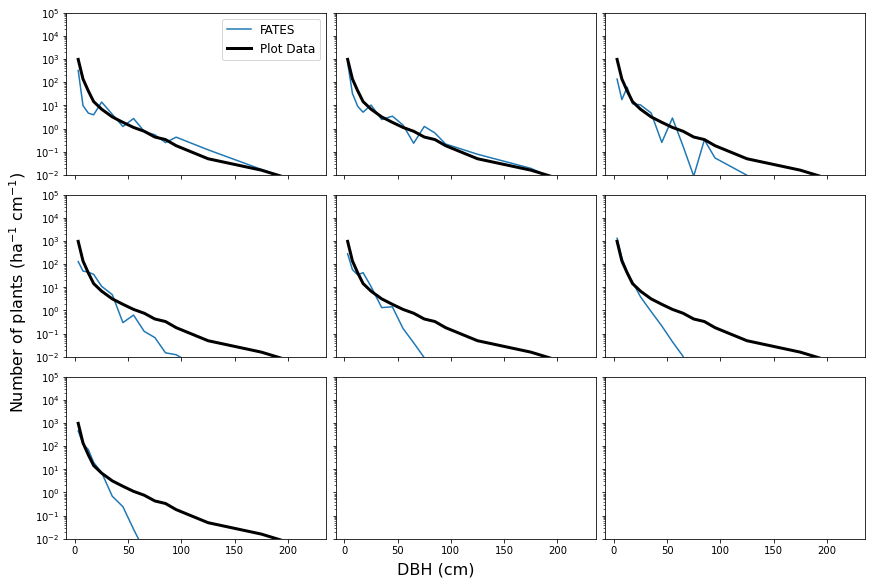

In [17]:
plot_nplant = dfss['nstem_size_ha.1']
plot_sd = plot_nplant.iloc[1:]/plot_sizebin_widths

fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for  i in range(0,ninst):
    nyears = int(len(fates_runs[i].variables['time'])/12)
    tave_start = (nyears-5)
    tave_stop = nyears
    nstem_size = monthly_to_annual(fates_runs[i].FATES_NPLANT_SZ) * 10000
    nstem_size = np.squeeze(nstem_size.isel(time=slice(tave_start,tave_stop)).mean(dim='time'))
    nstem_size = nstem_size.isel(fates_levscls=slice(1,nsizebins))  # remove first size bin (0-1)
    
    axs[i].plot(mids[1:], nstem_size/widths[1:], label = 'FATES')  
    axs[i].plot(plot_sizebin_mids, plot_sd, color='black',label = 'Plot Data', linewidth=3)
    axs[i].set_yscale('log')
    axs[i].set_ylim(0.01, 100000)

axs[0].legend(prop={'size':12})

    
fig1.supxlabel(r'DBH (cm)', fontsize=16)
fig1.supylabel(r'Number of plants (ha$^{-1}$ cm$^{-1}$)', fontsize=16)


### Leaf area index

In [18]:
for i in range(0,ninst) : 
    lai = fates_runs[i].FATES_LAI_PF
    lai = lai.isel(time=slice(start_time,stop_time))
    lai = lai.to_dataset(name='lai')
    lai.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_lai_p1_bci_{0}.nc'.format(i+1))

Text(0.02, 0.5, 'LAI (m2 m-2)')

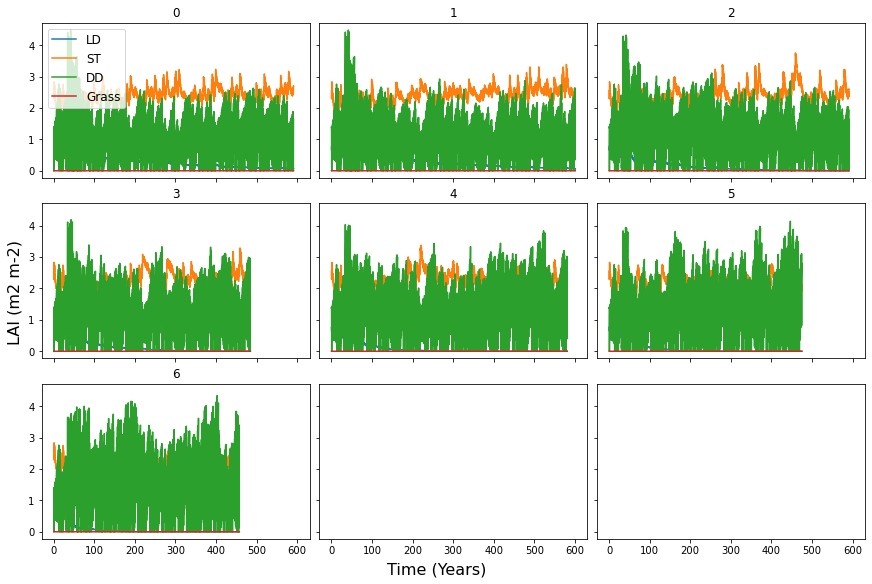

In [19]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for  i in range(0,ninst):
    time = fates_runs[i].variables['time'] / 365.
    lai = fates_runs[i].FATES_LAI_PF
    axs[i].plot(time, lai.isel(fates_levpft=0),label = 'LD')  
    axs[i].plot(time, lai.isel(fates_levpft=1), label = 'ST')   
    axs[i].plot(time, lai.isel(fates_levpft=2),  label = 'DD')   
    axs[i].plot(time, lai.isel(fates_levpft=3),  label = 'Grass')  
    axs[i].set_title(i)
    if i == 0:
        axs[i].legend(prop={'size':12})

fig1.supxlabel(r'Time (Years)', fontsize=16)
fig1.supylabel(r'LAI (m2 m-2)', fontsize=16)


### Crown area

In [20]:
for i in range(0,ninst) : 
    CA = monthly_to_annual(fates_runs[i].FATES_CROWNAREA_PF)
    CA = CA.isel(time=slice(start_time,stop_time)) * 10000
    CA = CA.to_dataset(name='CA')
    CA.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_CA_p1_bci_{0}.nc'.format(i+1))

Text(0.02, 0.5, 'Crown area (m2 ha-1)')

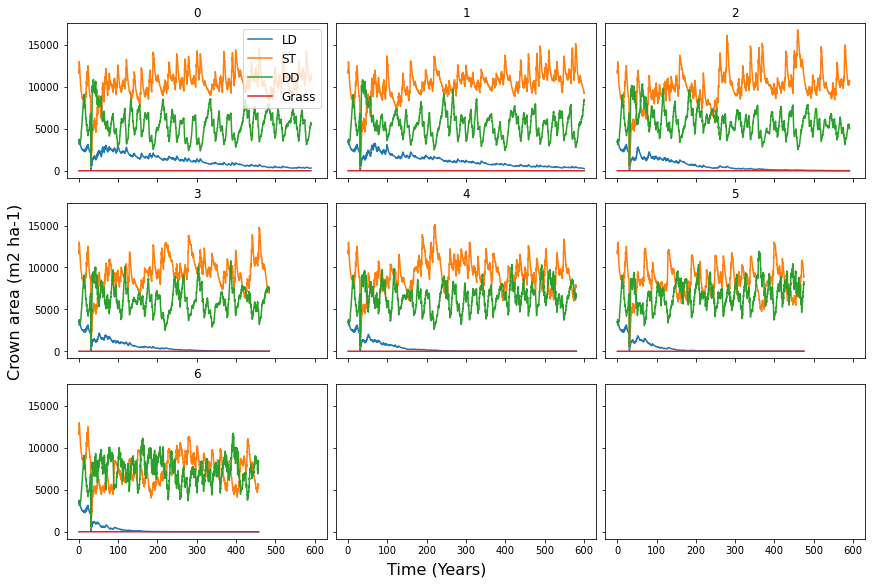

In [21]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for  i in range(0,ninst):
    time = fates_runs[i].variables['time'] / 365.
    CA = fates_runs[i].FATES_CROWNAREA_PF * 10000
    axs[i].plot(time, CA.isel(fates_levpft=0),label = 'LD')  
    axs[i].plot(time, CA.isel(fates_levpft=1), label = 'ST')   
    axs[i].plot(time, CA.isel(fates_levpft=2),  label = 'DD')   
    axs[i].plot(time, CA.isel(fates_levpft=3),  label = 'Grass')  
    axs[i].set_title(i)
    if i == 0:
        axs[i].legend(prop={'size':12})

fig1.supxlabel(r'Time (Years)', fontsize=16)
fig1.supylabel(r'Crown area (m2 ha-1)', fontsize=16)


### Basal area

In [22]:
for i in range(0,ninst) : 
    BA =  fa.scpf_to_scls_by_pft(fates_runs[i].FATES_BASALAREA_SZPF, fates_runs[i])
    BA = BA.sum(dim='fates_levscls')
    BA = monthly_to_annual(BA)
    BA = BA.isel(time=slice(start_time,stop_time)) * 10000
    BA = BA.to_dataset(name='BA')
    BA.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_BA_p1_bci_{0}.nc'.format(i+1))

Text(0.02, 0.5, 'Basal Area (m2 ha-1)')

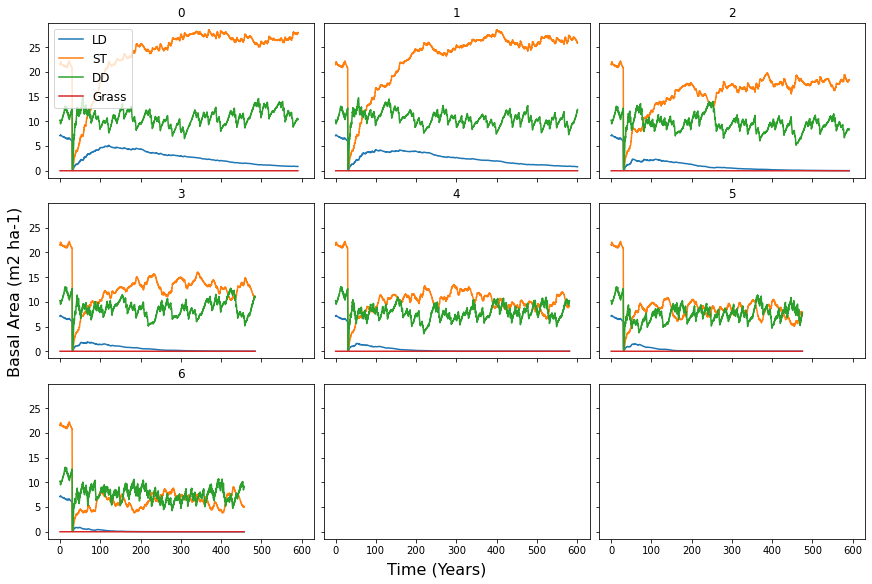

In [23]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in range(0,ninst):
    time = fates_runs[i].variables['time'] / 365.
    BA = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_BASALAREA_SZPF, fates_runs[i])
    BA = BA.sum(dim='fates_levscls') * 10000
    axs[i].plot(time, BA.isel(fates_levpft=0),label = 'LD')  
    axs[i].plot(time, BA.isel(fates_levpft=1), label = 'ST')   
    axs[i].plot(time, BA.isel(fates_levpft=2),  label = 'DD')   
    axs[i].plot(time, BA.isel(fates_levpft=3),  label = 'Grass')  
    axs[i].set_title(i)
    if i == 0:
        axs[i].legend(prop={'size':12})

fig1.supxlabel(r'Time (Years)', fontsize=16)
fig1.supylabel(r'Basal Area (m2 ha-1)', fontsize=16)


### Roughness length

In [24]:
for i in range(0,ninst) : 
    z0 = monthly_to_annual(fates_runs[i].Z0MG)
    z0 = z0.isel(time=slice(start_time,stop_time)) 
    z0 = z0.to_dataset(name='z0')
    z0.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_z0_p1_bci_{0}.nc'.format(i+1))

Text(0.02, 0.5, 'Roughness (m)')

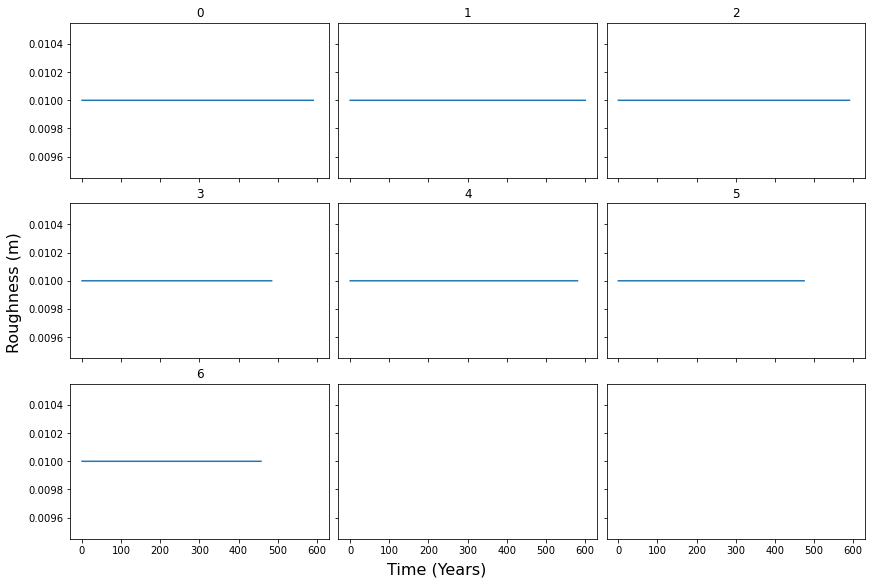

In [25]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for  i in range(0,ninst):
    time = fates_runs[i].variables['time'] / 365.
    z0 = fates_runs[i].Z0MG
    axs[i].plot(time, z0)   
    axs[i].set_title(i)
    
fig1.supxlabel(r'Time (Years)', fontsize=16)
fig1.supylabel(r'Roughness (m)', fontsize=16)


### Woody biomass growth

In [26]:
for i in range(0,ninst):
    WBgrowth = monthly_to_annual(fates_runs[i].FATES_SAPWOOD_ALLOC_PF + fates_runs[i].FATES_STRUCT_ALLOC_PF) * 31536000
    WBgrowth = WBgrowth.isel(time=slice(start_time,stop_time))
    WBgrowth = WBgrowth.to_dataset(name='WBgrowth')
    WBgrowth.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_WBgrowth_p1_bci_{0}.nc'.format(i+1))

''

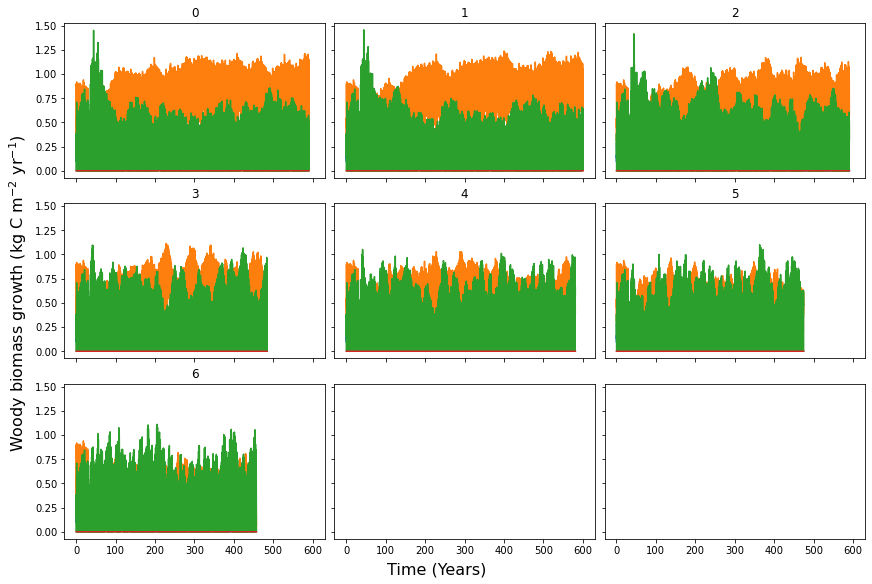

In [27]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for  i in range(0,ninst):
    time = fates_runs[i].variables['time'] / 365.
    WBgrowth = fates_runs[i].FATES_SAPWOOD_ALLOC_PF + fates_runs[i].FATES_STRUCT_ALLOC_PF * 31536000
    axs[i].plot(time, WBgrowth.isel(fates_levpft=0))  
    axs[i].plot(time, WBgrowth.isel(fates_levpft=1))  
    axs[i].plot(time, WBgrowth.isel(fates_levpft=2))  
    axs[i].plot(time, WBgrowth.isel(fates_levpft=3))  
    axs[i].set_title(i)
    
fig1.supxlabel(r'Time (Years)', fontsize=16)
fig1.supylabel(r'Woody biomass growth (kg C m$^{-2}$ yr$^{-1}$) ', fontsize=16)
 
;

### All growth

In [28]:
for i in range(0,ninst):
    npp = monthly_to_annual(fates_runs[i].FATES_NPP) * 86400 * 365
    npp = npp.isel(time=slice(start_time,stop_time))
    Bgrowth = npp.to_dataset(name='Bgrowth')
    Bgrowth.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_Bgrowth_p1_bci_{0}.nc'.format(i+1))

### Carbon  mass flux lost from alive wood due to mortality or other turnover process

#### Carbon starvation

In [29]:
for i in range(0,ninst):
    cmort_cstarv = monthly_to_annual(fates_runs[i].FATES_MORTALITY_CSTARV_CFLUX_PF) * 31536000
    cmort_cstarv = cmort_cstarv.isel(time=slice(start_time,stop_time))
    cmort_cstarv = cmort_cstarv.to_dataset(name='cmort_cstarv')
    cmort_cstarv.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_cmort_cstarv_p1_bci_{0}.nc'.format(i+1))

''

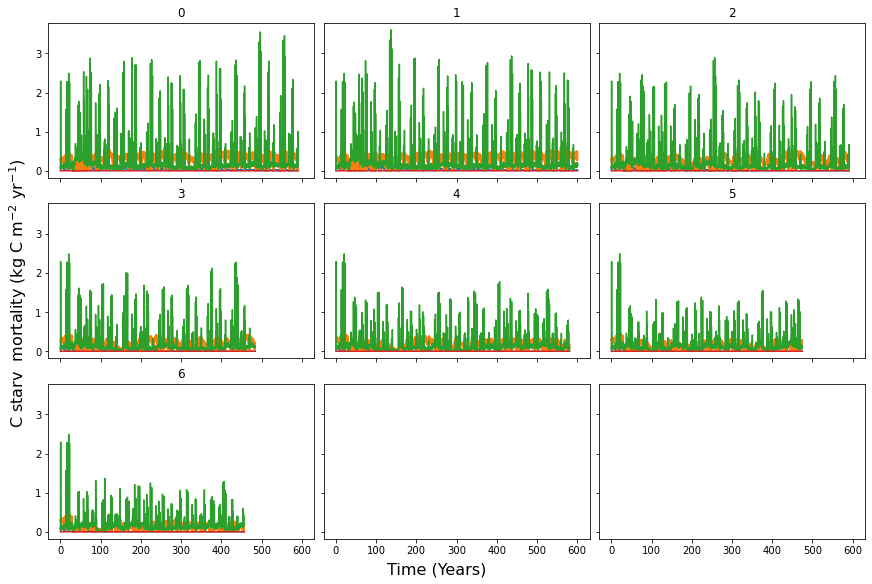

In [30]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for  i in range(0,ninst):
    time = fates_runs[i].variables['time'] / 365.
    cmort_cstarv = fates_runs[i].FATES_MORTALITY_CSTARV_CFLUX_PF * 31536000
    axs[i].plot(time, cmort_cstarv.isel(fates_levpft=0))  
    axs[i].plot(time, cmort_cstarv.isel(fates_levpft=1))  
    axs[i].plot(time, cmort_cstarv.isel(fates_levpft=2))  
    axs[i].plot(time, cmort_cstarv.isel(fates_levpft=3))  
    axs[i].set_title(i)
    
fig1.supxlabel(r'Time (Years)', fontsize=16)
fig1.supylabel(r'C starv  mortality (kg C m$^{-2}$ yr$^{-1}$) ', fontsize=16)
 
;

#### Hydraulic failure

In [31]:
for i in range(0,ninst):
    cmort_hydro = monthly_to_annual(fates_runs[i].FATES_MORTALITY_HYDRO_CFLUX_PF) * 31536000
    cmort_hydro = cmort_hydro.isel(time=slice(start_time,stop_time))
    cmort_hydro = cmort_hydro.to_dataset(name='cmort_hydro')
    cmort_hydro.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_cmort_hydro_p1_bci_{0}.nc'.format(i+1))

''

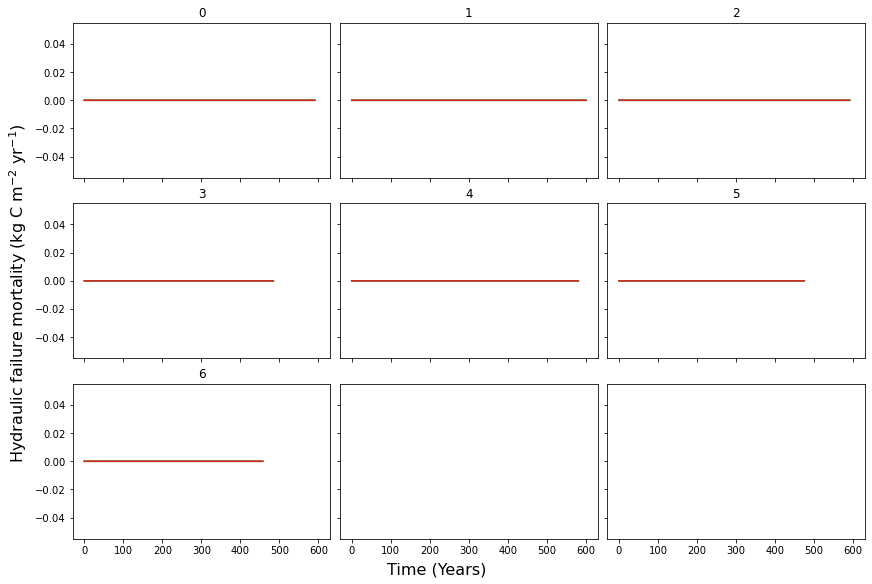

In [32]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for  i in range(0,ninst):
    time = fates_runs[i].variables['time'] / 365.
    cmort_hydro = fates_runs[i].FATES_MORTALITY_HYDRO_CFLUX_PF * 31536000
    axs[i].plot(time, cmort_hydro.isel(fates_levpft=0))  
    axs[i].plot(time, cmort_hydro.isel(fates_levpft=1))  
    axs[i].plot(time, cmort_hydro.isel(fates_levpft=2))  
    axs[i].plot(time, cmort_hydro.isel(fates_levpft=3))  
    axs[i].set_title(i)
    
fig1.supxlabel(r'Time (Years)', fontsize=16)
fig1.supylabel(r'Hydraulic failure mortality (kg C m$^{-2}$ yr$^{-1}$) ', fontsize=16)
 
;

#### Total cflux

In [33]:
for  i in range(0,ninst):

    # out 
    litter_in = monthly_to_annual(fates_runs[i].FATES_LITTER_IN) * 86400 * 365
    seed_decay = monthly_to_annual(fates_runs[i].FATES_SEED_DECAY_EL.sum(dim='fates_levelem')) * 86400 * 365
    loss = litter_in  + seed_decay
    loss = loss.isel(time=slice(start_time,stop_time))
    cmort = loss.to_dataset(name='cmort')
    cmort.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_cmort_p1_bci_{0}.nc'.format(i+1))

0
1
2
3
4
5
6


Text(0.5, 0.01, 'Time')

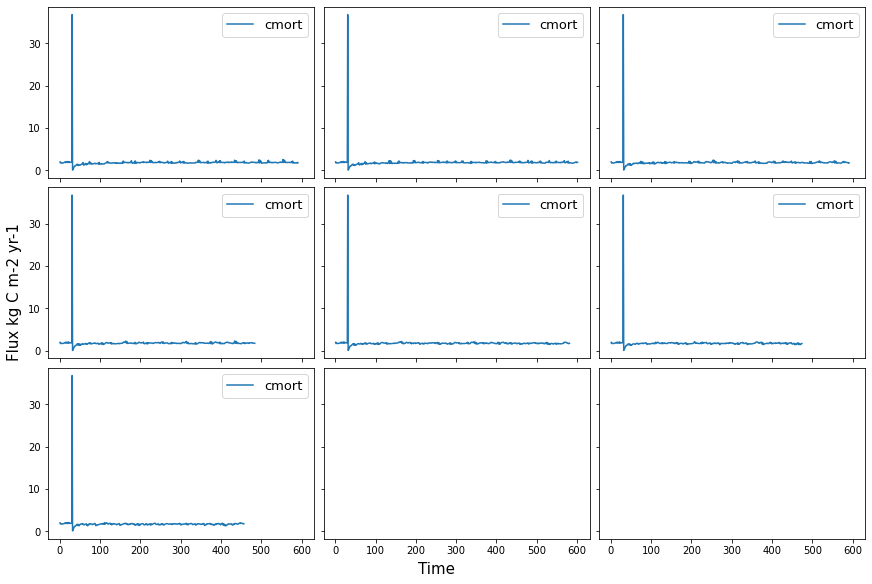

In [34]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in range(0,ninst):
    print(i)
    # out 
    litter_in = monthly_to_annual(fates_runs[i].FATES_LITTER_IN) * 86400 * 365
    seed_decay = monthly_to_annual(fates_runs[i].FATES_SEED_DECAY_EL.sum(dim='fates_levelem')) * 86400 * 365

    nyears = int(len(fates_runs[i].variables['time'])/12)
    time = np.linspace(1,nyears,nyears)
    
    axs[i].plot(time, litter_in + seed_decay, label = 'cmort')
    axs[i].legend(fontsize=13)
    
fig1.supylabel('Flux kg C m-2 yr-1', fontsize=15)
fig1.supxlabel('Time', fontsize=15)

### Check carbon budget

0
1
2
3
4
5
6


Text(0.5, 0.01, 'Time')

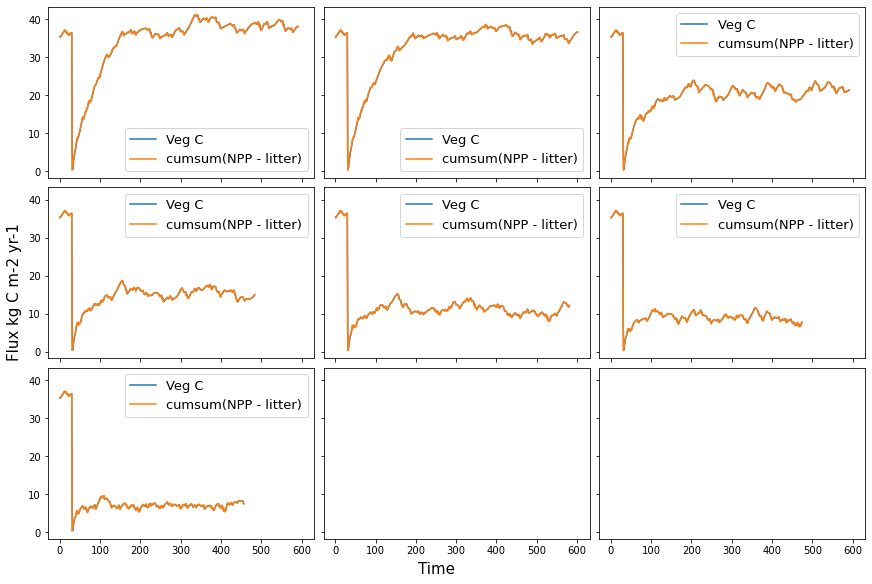

In [35]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in range(0,ninst):
    print(i)
    # out 
    litter_in = monthly_to_annual(fates_runs[i].FATES_LITTER_IN) * 86400 * 365
    seed_decay = monthly_to_annual(fates_runs[i].FATES_SEED_DECAY_EL.sum(dim='fates_levelem')) * 86400 * 365

    # in
    npp = monthly_to_annual(fates_runs[i].FATES_NPP) * 86400 * 365
    
    # net change
    net = np.cumsum(npp - litter_in - seed_decay) 
    
    # cveg 
    cveg_mon  = fates_runs[i].FATES_VEGC_PF.sum(dim='fates_levpft') + fates_runs[i].FATES_SEED_BANK
    cveg_init = cveg_mon[0]
    cveg = monthly_to_annual(cveg_mon)
    
    nyears = int(len(fates_runs[i].variables['time'])/12)
    time = np.linspace(1,nyears,nyears)
    
    axs[i].plot(time, cveg, label = 'Veg C')  
   # axs[i].plot(time, litter_in, label = 'litter')
    axs[i].plot(time, net + cveg_init, label = 'cumsum(NPP - litter)')
    axs[i].legend(fontsize=13)
    #axs[i].set_xlim(0,120)

fig1.supylabel('Flux kg C m-2 yr-1', fontsize=15)
fig1.supxlabel('Time', fontsize=15)
    
    
    
    

### Stem number flux lost  from vegetation due to mortality or other turnover processses

#### Background

In [36]:
for i in range(0,ninst):
    stemmort_background = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_MORTALITY_BACKGROUND_SZPF, fates_runs[i])
    stemmort_background = monthly_to_annual(stemmort_background)
    stemmort_background = stemmort_background.isel(time=slice(start_time,stop_time)) * 10000
    stemmort_background = stemmort_background.isel(fates_levscls=slice(1,nsizebins))
    stemmort_background = stemmort_background.to_dataset(name='stemmort_background')
    stemmort_background.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_stemmort_background_p1_bci_{0}.nc'.format(i+1))


''

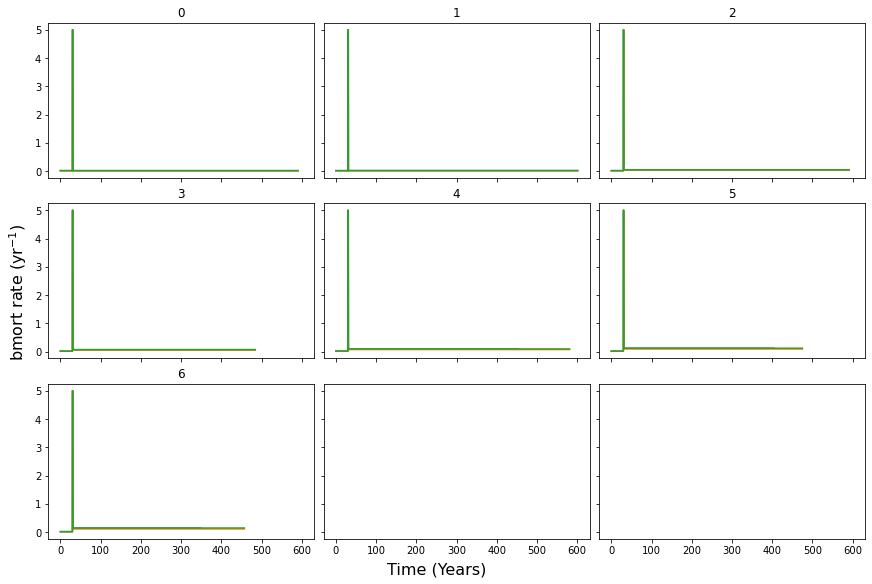

In [37]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in range(0,ninst):
    
    bmort = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_MORTALITY_BACKGROUND_SZPF, fates_runs[i])
    bmort = bmort.isel(fates_levscls=slice(1,nsizebins))
    bmort_pf = bmort.sum(dim='fates_levscls')

    nplant = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_NPLANT_SZPF, fates_runs[i]) 
    nplant = nplant.isel(fates_levscls=slice(1,nsizebins))
    nplant_pf = nplant.sum(dim='fates_levscls')

    time = fates_runs[i].variables['time'] / 365.
    bmort = bmort_pf/nplant_pf
    axs[i].plot(time, bmort.isel(fates_levpft=0))  
    axs[i].plot(time, bmort.isel(fates_levpft=1))  
    axs[i].plot(time, bmort.isel(fates_levpft=2))  
    axs[i].plot(time, bmort.isel(fates_levpft=3))  
    axs[i].set_title(i)
    
fig1.supxlabel(r'Time (Years)', fontsize=16)
fig1.supylabel(r'bmort rate (yr$^{-1}$)', fontsize=16)
;

#### Hydraulic

In [38]:
for i in range(0,ninst):
    stemmort_hydraulic = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_MORTALITY_HYDRAULIC_SZPF, fates_runs[i])
    stemmort_hydraulic = monthly_to_annual(stemmort_hydraulic)
    stemmort_hydraulic = stemmort_hydraulic.isel(time=slice(start_time,stop_time)) * 10000
    stemmort_hydraulic = stemmort_hydraulic.isel(fates_levscls=slice(1,nsizebins))
    stemmort_hydraulic = stemmort_hydraulic.to_dataset(name='stemmort_hydraulic')
    stemmort_hydraulic.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_stemmort_hydraulic_p1_bci_{0}.nc'.format(i+1))


''

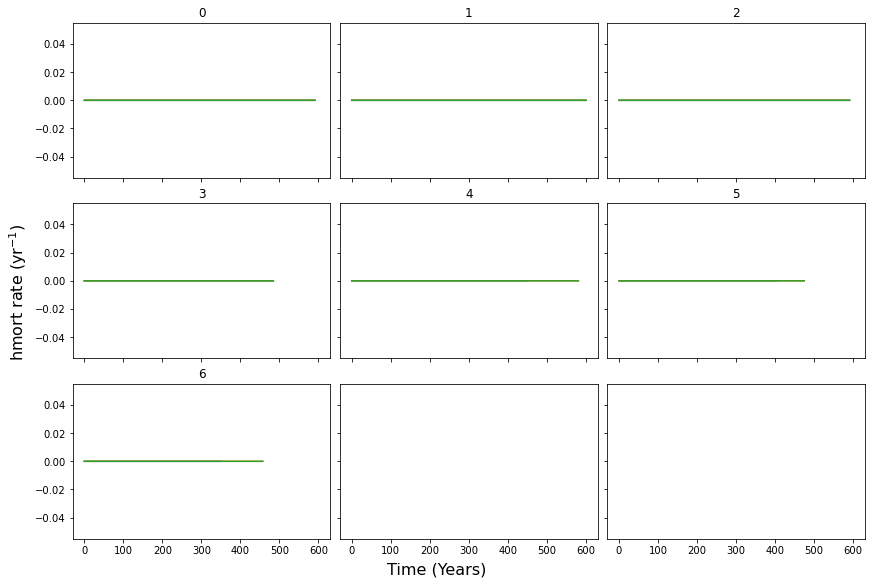

In [39]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in range(0,ninst):
    
    hmort = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_MORTALITY_HYDRAULIC_SZPF, fates_runs[i])
    hmort = hmort.isel(fates_levscls=slice(1,nsizebins))
    hmort_pf = hmort.sum(dim='fates_levscls')

    nplant = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_NPLANT_SZPF, fates_runs[i]) 
    nplant = nplant.isel(fates_levscls=slice(1,nsizebins))
    nplant_pf = nplant.sum(dim='fates_levscls')

    time = fates_runs[i].variables['time'] / 365.
    hmort = hmort_pf/nplant_pf
    axs[i].plot(time, hmort.isel(fates_levpft=0))  
    axs[i].plot(time, hmort.isel(fates_levpft=1))  
    axs[i].plot(time, hmort.isel(fates_levpft=2))  
    axs[i].plot(time, hmort.isel(fates_levpft=3))  
    axs[i].set_title(i)
    
fig1.supxlabel(r'Time (Years)', fontsize=16)
fig1.supylabel(r'hmort rate (yr$^{-1}$)', fontsize=16)
;

#### Carbon starvation

In [40]:
for i in range(0,ninst):
    stemmort_cstarv = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_MORTALITY_CSTARV_SZPF, fates_runs[i])
    stemmort_cstarv = monthly_to_annual(stemmort_cstarv)
    stemmort_cstarv = stemmort_cstarv.isel(time=slice(start_time,stop_time)) * 10000
    stemmort_cstarv = stemmort_cstarv.isel(fates_levscls=slice(1,nsizebins))
    stemmort_cstarv = stemmort_cstarv.to_dataset(name='stemmort_cstarv')
    stemmort_cstarv.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_stemmort_cstarv_p1_bci_{0}.nc'.format(i+1))


''

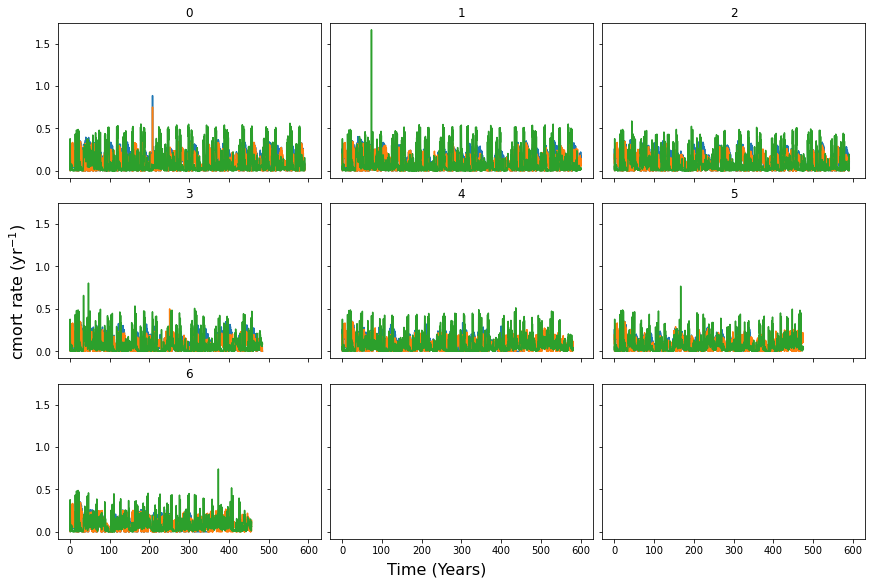

In [41]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in range(0,ninst):
    
    cmort = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_MORTALITY_CSTARV_SZPF, fates_runs[i])
    cmort = cmort.isel(fates_levscls=slice(1,nsizebins))
    cmort_pf = cmort.sum(dim='fates_levscls')

    nplant = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_NPLANT_SZPF, fates_runs[i]) 
    nplant = nplant.isel(fates_levscls=slice(1,nsizebins))
    nplant_pf = nplant.sum(dim='fates_levscls')

    time = fates_runs[i].variables['time'] / 365.
    cmort = cmort_pf/nplant_pf
    axs[i].plot(time, cmort.isel(fates_levpft=0))  
    axs[i].plot(time, cmort.isel(fates_levpft=1))  
    axs[i].plot(time, cmort.isel(fates_levpft=2))  
    axs[i].plot(time, cmort.isel(fates_levpft=3))  
    axs[i].set_title(i)
    
fig1.supxlabel(r'Time (Years)', fontsize=16)
fig1.supylabel(r'cmort rate (yr$^{-1}$)', fontsize=16)
;

#### Impact

In [42]:
for i in range(0,ninst):
    stemmort_impact = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_MORTALITY_IMPACT_SZPF, fates_runs[i])
    stemmort_impact = monthly_to_annual(stemmort_impact)
    stemmort_impact = stemmort_impact.isel(time=slice(start_time,stop_time)) * 10000
    stemmort_impact = stemmort_impact.isel(fates_levscls=slice(1,nsizebins))
    stemmort_impact = stemmort_impact.to_dataset(name='stemmort_impact')
    stemmort_impact.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_stemmort_impact_p1_bci_{0}.nc'.format(i+1))


''

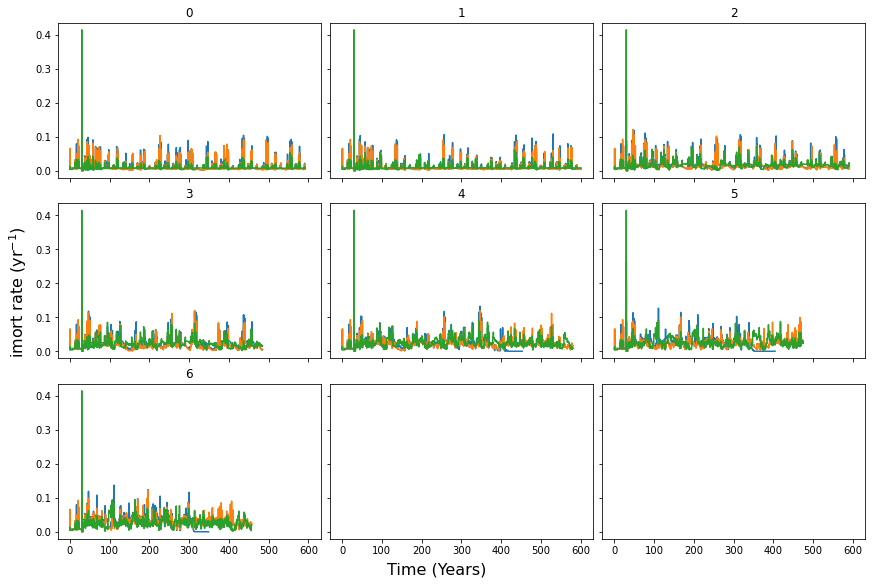

In [43]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in range(0,ninst):
    
    imort = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_MORTALITY_IMPACT_SZPF, fates_runs[i])
    imort = imort.isel(fates_levscls=slice(1,nsizebins))
    imort_pf = imort.sum(dim='fates_levscls')

    nplant = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_NPLANT_SZPF, fates_runs[i]) 
    nplant = nplant.isel(fates_levscls=slice(1,nsizebins))
    nplant_pf = nplant.sum(dim='fates_levscls')

    time = fates_runs[i].variables['time'] / 365.
    imort = imort_pf/nplant_pf
    axs[i].plot(time, imort.isel(fates_levpft=0))  
    axs[i].plot(time, imort.isel(fates_levpft=1))  
    axs[i].plot(time, imort.isel(fates_levpft=2))  
    axs[i].plot(time, imort.isel(fates_levpft=3))  
    axs[i].set_title(i)
    
fig1.supxlabel(r'Time (Years)', fontsize=16)
fig1.supylabel(r'imort rate (yr$^{-1}$)', fontsize=16)
;

#### Termination

In [44]:
for i in range(0,ninst):
    stemmort_term = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_MORTALITY_TERMINATION_SZPF, fates_runs[i])
    stemmort_term = monthly_to_annual(stemmort_term)
    stemmort_term = stemmort_term.isel(time=slice(start_time,stop_time)) * 10000
    stemmort_term = stemmort_term.isel(fates_levscls=slice(1,nsizebins))
    stemmort_term = stemmort_term.to_dataset(name='stemmort_term')
    stemmort_term.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_stemmort_term_p1_bci_{0}.nc'.format(i+1))


''

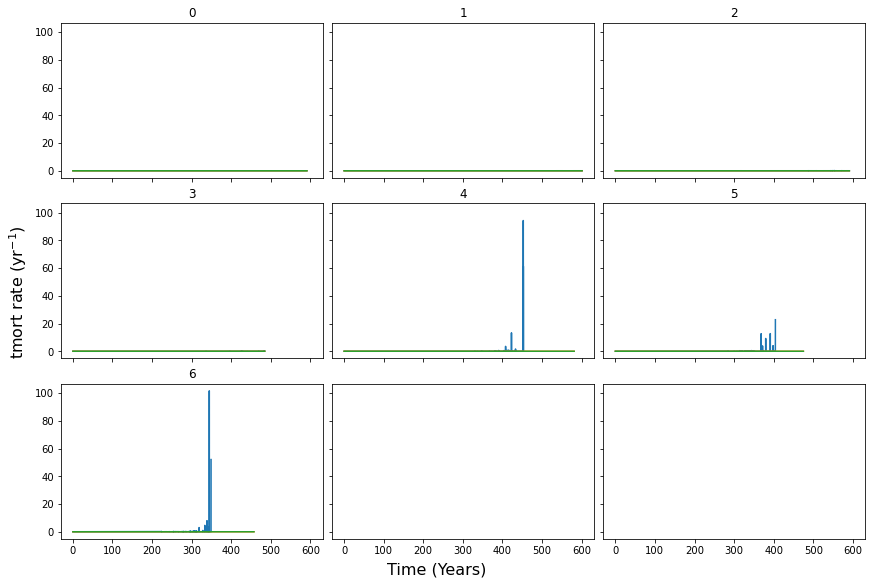

In [45]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in range(0,ninst):
    
    tmort = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_MORTALITY_TERMINATION_SZPF, fates_runs[i])
    tmort = tmort.isel(fates_levscls=slice(1,nsizebins))
    tmort_pf = tmort.sum(dim='fates_levscls')

    nplant = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_NPLANT_SZPF, fates_runs[i]) 
    nplant = nplant.isel(fates_levscls=slice(1,nsizebins))
    nplant_pf = nplant.sum(dim='fates_levscls')

    time = fates_runs[i].variables['time'] / 365.
    tmort = tmort_pf/nplant_pf
    axs[i].plot(time, tmort.isel(fates_levpft=0))  
    axs[i].plot(time, tmort.isel(fates_levpft=1))  
    axs[i].plot(time, tmort.isel(fates_levpft=2))  
    axs[i].plot(time, tmort.isel(fates_levpft=3))  
    axs[i].set_title(i)
    
fig1.supxlabel(r'Time (Years)', fontsize=16)
fig1.supylabel(r'tmort rate (yr$^{-1}$)', fontsize=16)
;

#### Freezing

In [46]:
for i in range(0,ninst):
    stemmort_freeze = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_MORTALITY_FREEZING_SZPF, fates_runs[i])
    stemmort_freeze = monthly_to_annual(stemmort_freeze)
    stemmort_freeze = stemmort_freeze.isel(time=slice(start_time,stop_time)) * 10000
    stemmort_freeze = stemmort_freeze.isel(fates_levscls=slice(1,nsizebins))
    stemmort_freeze = stemmort_freeze.to_dataset(name='stemmort_freeze')
    stemmort_freeze.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_stemmort_freeze_p1_bci_{0}.nc'.format(i+1))


''

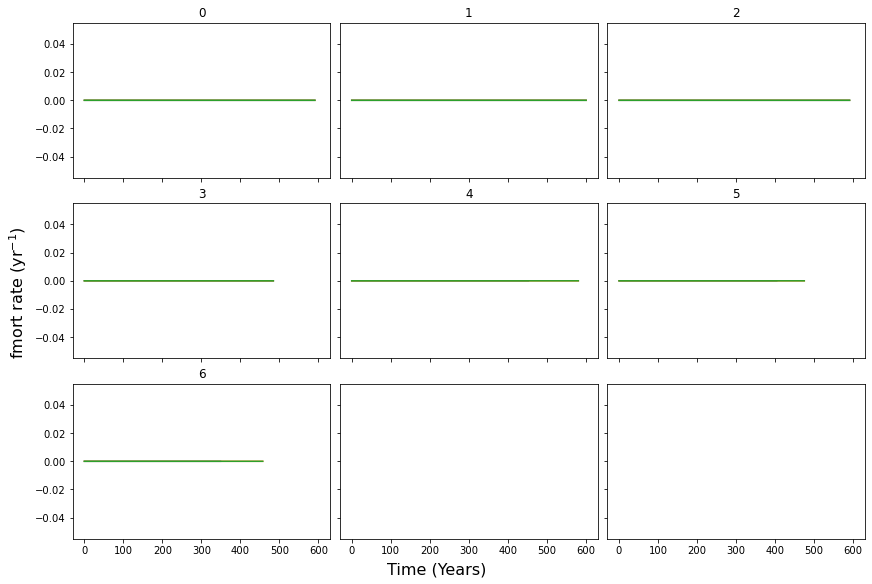

In [47]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in range(0,ninst):
    
    fmort = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_MORTALITY_FREEZING_SZPF, fates_runs[i])
    fmort = fmort.isel(fates_levscls=slice(1,nsizebins))
    fmort_pf = fmort.sum(dim='fates_levscls')

    nplant = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_NPLANT_SZPF, fates_runs[i]) 
    nplant = nplant.isel(fates_levscls=slice(1,nsizebins))
    nplant_pf = nplant.sum(dim='fates_levscls')

    time = fates_runs[i].variables['time'] / 365.
    fmort = fmort_pf/nplant_pf
    axs[i].plot(time, fmort.isel(fates_levpft=0))  
    axs[i].plot(time, fmort.isel(fates_levpft=1))  
    axs[i].plot(time, fmort.isel(fates_levpft=2))  
    axs[i].plot(time, fmort.isel(fates_levpft=3))  
    axs[i].set_title(i)
    
fig1.supxlabel(r'Time (Years)', fontsize=16)
fig1.supylabel(r'fmort rate (yr$^{-1}$)', fontsize=16)
;

#### Total stem mortality canopy

In [48]:
for i in range(0,ninst):
    stemmort = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_MORTALITY_CANOPY_SZPF, fates_runs[i])
    stemmort = monthly_to_annual(stemmort)
    stemmort = stemmort.isel(time=slice(start_time,stop_time)) * 10000
    stemmort = stemmort.isel(fates_levscls=slice(1,nsizebins))
    stemmort = stemmort.to_dataset(name='stemmort')
    stemmort.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_stemmort_p1_bci_overstory_{0}.nc'.format(i+1))


''

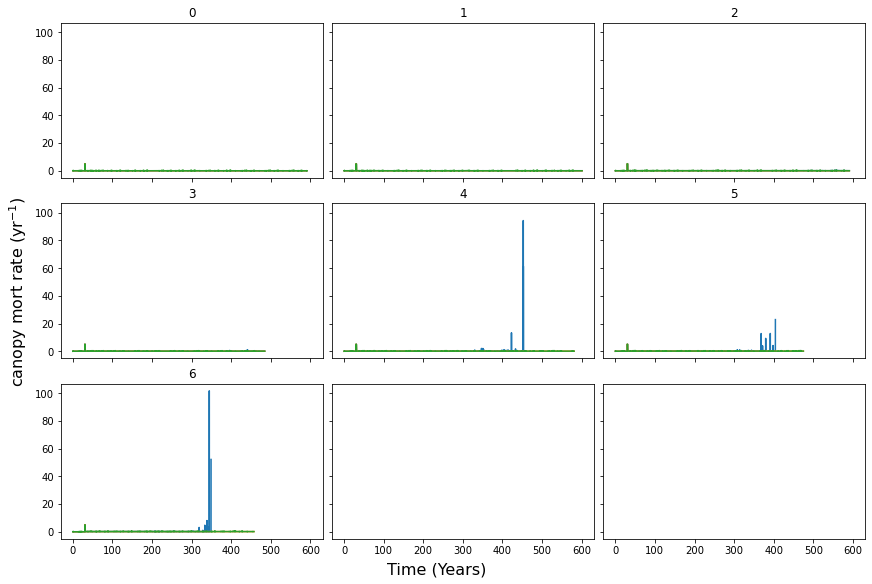

In [49]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in range(0,ninst):
    
    mort = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_MORTALITY_CANOPY_SZPF, fates_runs[i])
    mort = mort.isel(fates_levscls=slice(1,nsizebins))
    mort_pf = mort.sum(dim='fates_levscls')

    nplant = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_NPLANT_CANOPY_SZPF, fates_runs[i]) 
    nplant = nplant.isel(fates_levscls=slice(1,nsizebins))
    nplant_pf = nplant.sum(dim='fates_levscls')

    time = fates_runs[i].variables['time'] / 365.
    mort = mort_pf/nplant_pf
    axs[i].plot(time, mort.isel(fates_levpft=0))  
    axs[i].plot(time, mort.isel(fates_levpft=1))  
    axs[i].plot(time, mort.isel(fates_levpft=2))  
    axs[i].plot(time, mort.isel(fates_levpft=3))  
    axs[i].set_title(i)
    
fig1.supxlabel(r'Time (Years)', fontsize=16)
fig1.supylabel(r'canopy mort rate (yr$^{-1}$)', fontsize=16)
;

#### Total stem mortality understory

In [50]:
for i in range(0,ninst):
    stemmort = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_MORTALITY_USTORY_SZPF, fates_runs[i])
    stemmort = monthly_to_annual(stemmort)
    stemmort = stemmort.isel(time=slice(start_time,stop_time)) * 10000
    stemmort = stemmort.isel(fates_levscls=slice(1,nsizebins))
    stemmort = stemmort.to_dataset(name='stemmort')
    stemmort.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_stemmort_p1_bci_understory_{0}.nc'.format(i+1))


''

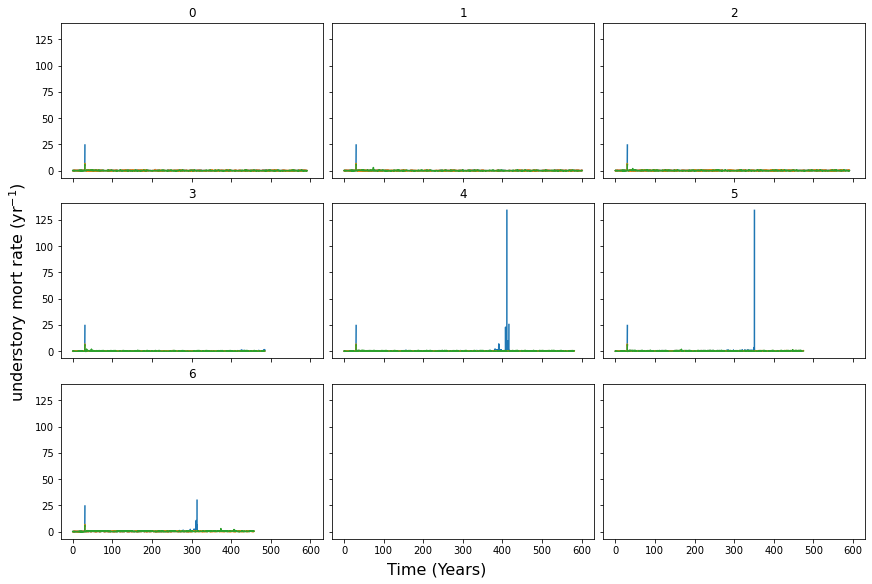

In [51]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in range(0,ninst):
    
    mort = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_MORTALITY_USTORY_SZPF, fates_runs[i])
    mort = mort.isel(fates_levscls=slice(1,nsizebins))
    mort_pf = mort.sum(dim='fates_levscls')

    nplant = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_NPLANT_USTORY_SZPF, fates_runs[i]) 
    nplant = nplant.isel(fates_levscls=slice(1,nsizebins))
    nplant_pf = nplant.sum(dim='fates_levscls')

    time = fates_runs[i].variables['time'] / 365.
    mort = mort_pf/nplant_pf
    axs[i].plot(time, mort.isel(fates_levpft=0))  
    axs[i].plot(time, mort.isel(fates_levpft=1))  
    axs[i].plot(time, mort.isel(fates_levpft=2))  
    axs[i].plot(time, mort.isel(fates_levpft=3))  
    axs[i].set_title(i)
    
fig1.supxlabel(r'Time (Years)', fontsize=16)
fig1.supylabel(r'understory mort rate (yr$^{-1}$)', fontsize=16)
;

#### Number of plants - understory

In [52]:
for i in range(0,ninst):
    nplant = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_NPLANT_USTORY_SZPF, fates_runs[i])
    nplant = monthly_to_annual(nplant)
    nplant = nplant.isel(time=slice(start_time,stop_time)) * 10000
    nplant = nplant.isel(fates_levscls=slice(1,nsizebins))
    nlant = nplant.to_dataset(name='nplant_size')
    nplant.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_nstem_size_pft_p1_bci_understory_{0}.nc'.format(i+1))


''

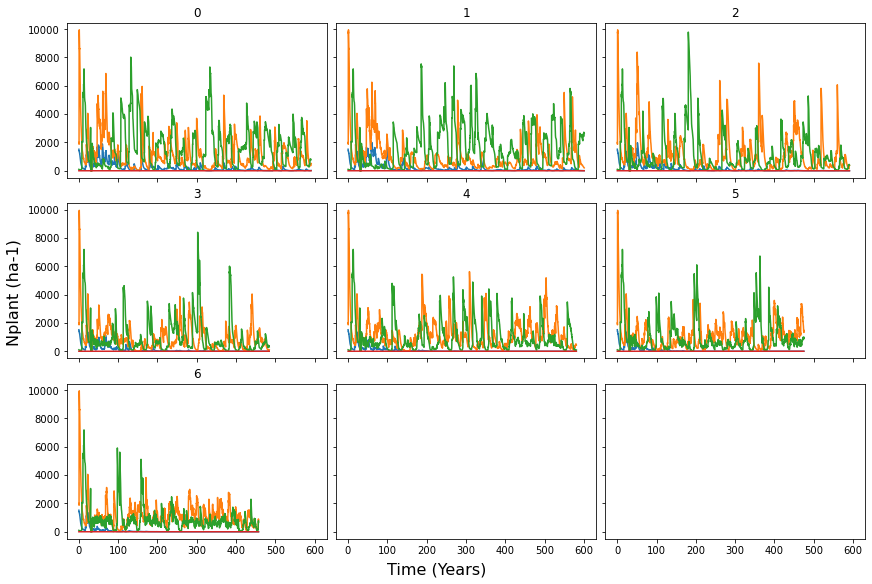

In [53]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in range(0,ninst):
    
    nplant = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_NPLANT_USTORY_SZPF, fates_runs[i]) * 10000
    nplant = nplant.isel(fates_levscls=slice(1,nsizebins))
    nplant = nplant.sum(dim='fates_levscls')
    time = fates_runs[i].variables['time'] / 365.
    axs[i].plot(time, nplant.isel(fates_levpft=0))  
    axs[i].plot(time, nplant.isel(fates_levpft=1))  
    axs[i].plot(time, nplant.isel(fates_levpft=2))  
    axs[i].plot(time, nplant.isel(fates_levpft=3))  
    axs[i].set_title(i)
    
fig1.supxlabel(r'Time (Years)', fontsize=16)
fig1.supylabel(r'Nplant (ha-1)', fontsize=16)
;

### NPLANT - canopy 

In [54]:
for i in range(0,ninst):
    nplant = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_NPLANT_CANOPY_SZPF, fates_runs[i])
    nplant = monthly_to_annual(nplant)
    nplant = nplant.isel(time=slice(start_time,stop_time)) * 10000
    nplant = nplant.isel(fates_levscls=slice(1,nsizebins))
    nlant = nplant.to_dataset(name='nplant_size')
    nplant.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_nstem_size_pft_p1_bci_overstory_{0}.nc'.format(i+1))


''

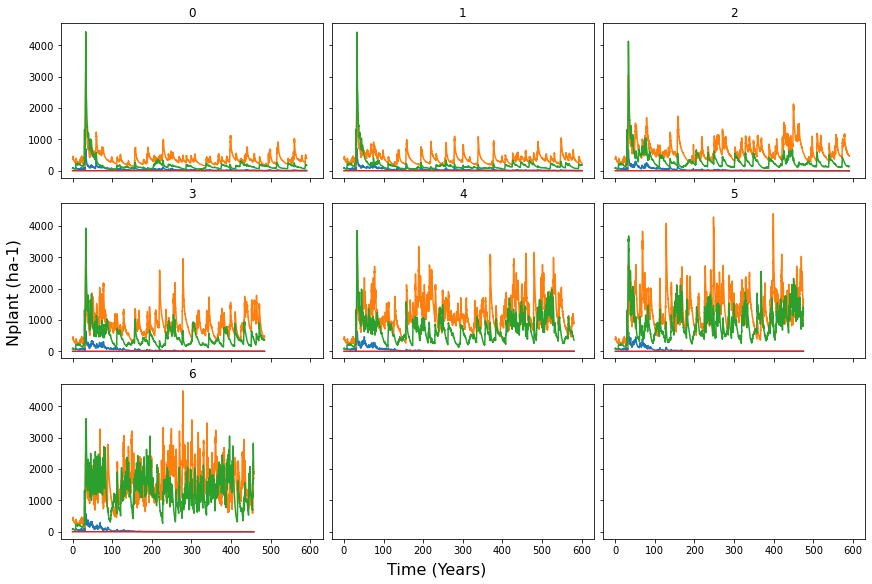

In [55]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in range(0,ninst):
    
    nplant = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_NPLANT_CANOPY_SZPF, fates_runs[i]) * 10000
    nplant = nplant.isel(fates_levscls=slice(1,nsizebins))
    nplant = nplant.sum(dim='fates_levscls')
    time = fates_runs[i].variables['time'] / 365.
    axs[i].plot(time, nplant.isel(fates_levpft=0))  
    axs[i].plot(time, nplant.isel(fates_levpft=1))  
    axs[i].plot(time, nplant.isel(fates_levpft=2))  
    axs[i].plot(time, nplant.isel(fates_levpft=3))  
    axs[i].set_title(i)
    
fig1.supxlabel(r'Time (Years)', fontsize=16)
fig1.supylabel(r'Nplant (ha-1)', fontsize=16)
;

In [56]:
for i in range(0,ninst):
    nplant = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_NPLANT_SZPF, fates_runs[i])
    nplant = monthly_to_annual(nplant)
    nplant = nplant.isel(time=slice(start_time,stop_time)) * 10000
    nplant = nplant.isel(fates_levscls=slice(1,nsizebins))
    nlant = nplant.to_dataset(name='nplant_size')
    nplant.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_nstem_size_pft_p1_bci_{0}.nc'.format(i+1))


''

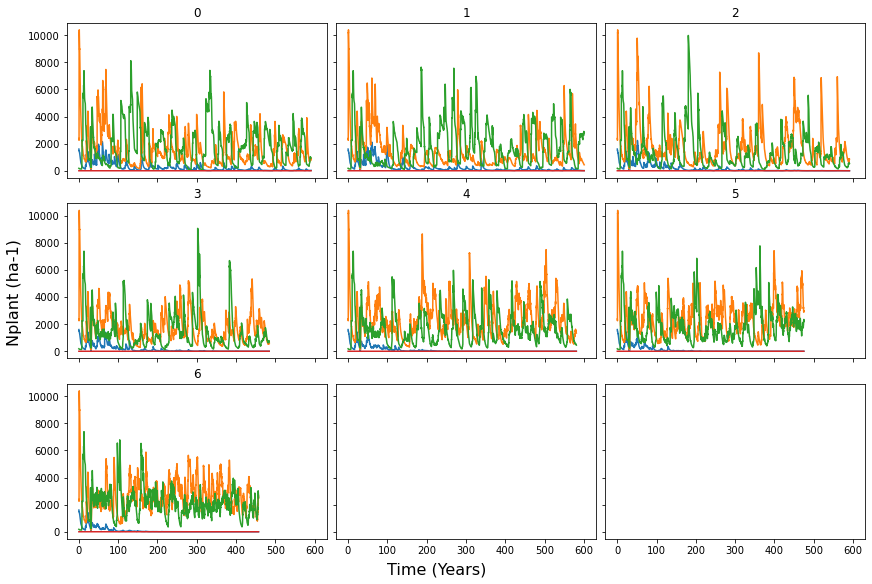

In [57]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in range(0,ninst):
    
    nplant = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_NPLANT_SZPF, fates_runs[i]) * 10000
    nplant = nplant.isel(fates_levscls=slice(1,nsizebins))
    nplant = nplant.sum(dim='fates_levscls')
    time = fates_runs[i].variables['time'] / 365.
    axs[i].plot(time, nplant.isel(fates_levpft=0))  
    axs[i].plot(time, nplant.isel(fates_levpft=1))  
    axs[i].plot(time, nplant.isel(fates_levpft=2))  
    axs[i].plot(time, nplant.isel(fates_levpft=3))  
    axs[i].set_title(i)
    
fig1.supxlabel(r'Time (Years)', fontsize=16)
fig1.supylabel(r'Nplant (ha-1)', fontsize=16)
;

### Carbon mass flux out of atmosphere due to GPP on land

In [58]:
for i in range(0,ninst) : 
    gpp = monthly_to_annual(fates_runs[i].FATES_GPP_PF)
    gpp = gpp.isel(time=slice(start_time,stop_time))
    gpp = gpp.to_dataset(name='gpp')
    gpp.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_gpp_p1_bci_{0}.nc'.format(i+1))

Text(0.02, 0.5, 'GPP C (kg C m-2 s-1)')

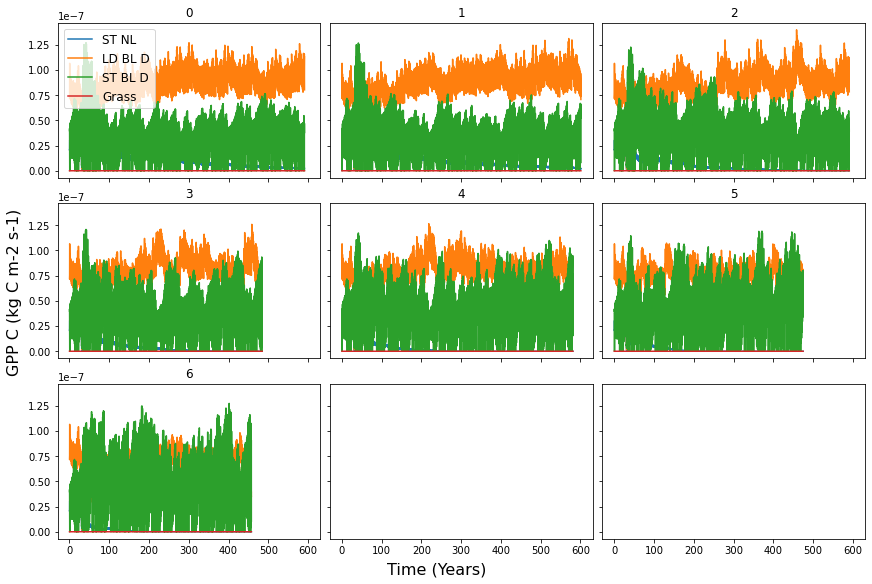

In [59]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for  i in range(0,ninst):
    gpp = fates_runs[i].FATES_GPP_PF
    time = fates_runs[i].variables['time'] / 365.
    axs[i].plot(time, gpp.isel(fates_levpft=0),label = 'ST NL')  
    axs[i].plot(time, gpp.isel(fates_levpft=1), label = 'LD BL D')   
    axs[i].plot(time, gpp.isel(fates_levpft=2),  label = 'ST BL D')   
    axs[i].plot(time, gpp.isel(fates_levpft=3),  label = 'Grass')  
    axs[i].set_title(i)
    if i == 0:
        axs[i].legend(prop={'size':12})

fig1.supxlabel(r'Time (Years)', fontsize=16)
fig1.supylabel(r'GPP C (kg C m-2 s-1)', fontsize=16)        

### Carbon mass flux out of atmosphere due to NPP on land

In [60]:
for i in range(0,ninst) : 
    npp = monthly_to_annual(fates_runs[i].FATES_NPP_PF)
    npp = npp.isel(time=slice(start_time,stop_time))
    npp = npp.to_dataset(name='npp')
    npp.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_npp_p1_bci_{0}.nc'.format(i+1))

Text(0.02, 0.5, 'NPP C (kg C m-2 s-1)')

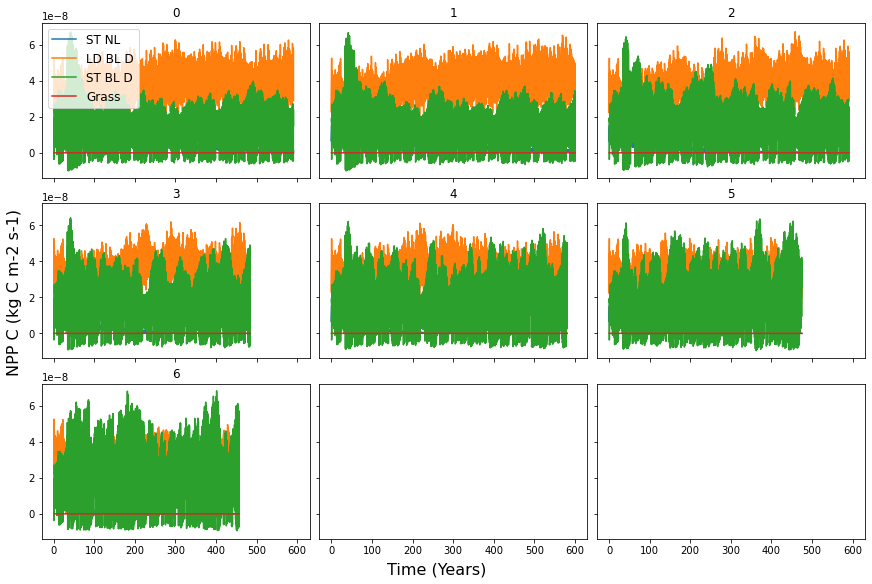

In [61]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for  i in range(0,ninst):
    npp = fates_runs[i].FATES_NPP_PF
    time = fates_runs[i].variables['time'] / 365.
    axs[i].plot(time, npp.isel(fates_levpft=0),label = 'ST NL')  
    axs[i].plot(time, npp.isel(fates_levpft=1), label = 'LD BL D')   
    axs[i].plot(time, npp.isel(fates_levpft=2),  label = 'ST BL D')   
    axs[i].plot(time, npp.isel(fates_levpft=3),  label = 'Grass')  
    axs[i].set_title(i)
    if i == 0:
        axs[i].legend(prop={'size':12})

fig1.supxlabel(r'Time (Years)', fontsize=16)
fig1.supylabel(r'NPP C (kg C m-2 s-1)', fontsize=16)        

### Carbon mass flux out of atmosphere due to net biospheric production on land

In [62]:
for i in range(0,ninst): 
    nbp_ens = monthly_to_annual(fates_runs[i].FATES_NEP + fates_runs[i].FATES_FIRE_CLOSS) 
    nbp_ens = nbp_ens.isel(time=slice(start_time,stop_time))
    nbp = nbp_ens.to_dataset(name='nbp')
    nbp.to_netcdf('/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/outputs/bci/high_co2_p1/FATES_nbp_p1_bci_{0}.nc'.format(i+1))


Text(0.02, 0.5, 'NBP C (kg C m-2 s-1)')

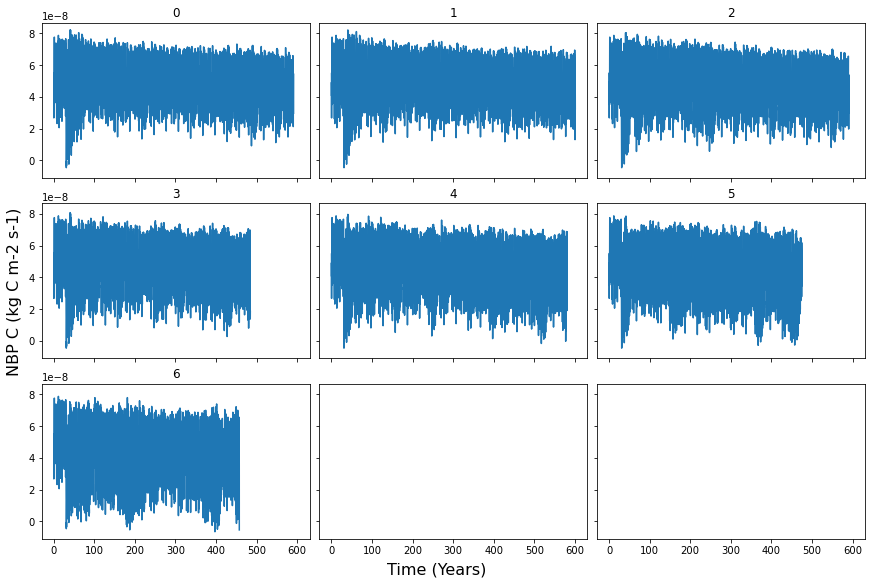

In [63]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in range(0,ninst):
    time = fates_runs[i].variables['time'] / 365.
    nbp_ens = fates_runs[i].FATES_NEP + fates_runs[i].FATES_FIRE_CLOSS
    axs[i].plot(time, nbp_ens)   
    axs[i].set_title(i)

fig1.supxlabel(r'Time (Years)', fontsize=16)
fig1.supylabel(r'NBP C (kg C m-2 s-1)', fontsize=16)        